In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

import json
from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet, UNet_conditional
from torchvision.transforms import v2
from matplotlib import pyplot as plt

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

with open("labels/pokedex.json") as json_data:
    data = json.load(json_data)

height = [float(str(d['profile']['height']).split()[0]) for d in data]
height = torch.tensor(height, device=device)
#height

types = [d['type'] for d in data]
all_types = list(set([d[0] for d in types]))
types = torch.tensor([all_types.index(t[0]) for t in types], device=device)

contour = load_contour().to(device)
contour.shape

torch.Size([3, 386, 1, 64, 64])

In [2]:
T = 200
beta = torch.linspace(0.04, 0.04, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(0.0003, device='cuda:0')

In [3]:
alpha_

tensor([9.6000e-01, 9.2160e-01, 8.8474e-01, 8.4935e-01, 8.1537e-01, 7.8276e-01,
        7.5145e-01, 7.2139e-01, 6.9253e-01, 6.6483e-01, 6.3824e-01, 6.1271e-01,
        5.8820e-01, 5.6467e-01, 5.4209e-01, 5.2040e-01, 4.9959e-01, 4.7960e-01,
        4.6042e-01, 4.4200e-01, 4.2432e-01, 4.0735e-01, 3.9106e-01, 3.7541e-01,
        3.6040e-01, 3.4598e-01, 3.3214e-01, 3.1886e-01, 3.0610e-01, 2.9386e-01,
        2.8210e-01, 2.7082e-01, 2.5999e-01, 2.4959e-01, 2.3960e-01, 2.3002e-01,
        2.2082e-01, 2.1199e-01, 2.0351e-01, 1.9537e-01, 1.8755e-01, 1.8005e-01,
        1.7285e-01, 1.6593e-01, 1.5930e-01, 1.5292e-01, 1.4681e-01, 1.4094e-01,
        1.3530e-01, 1.2989e-01, 1.2469e-01, 1.1970e-01, 1.1491e-01, 1.1032e-01,
        1.0591e-01, 1.0167e-01, 9.7602e-02, 9.3698e-02, 8.9950e-02, 8.6352e-02,
        8.2898e-02, 7.9582e-02, 7.6399e-02, 7.3343e-02, 7.0409e-02, 6.7593e-02,
        6.4889e-02, 6.2294e-02, 5.9802e-02, 5.7410e-02, 5.5113e-02, 5.2909e-02,
        5.0793e-02, 4.8761e-02, 4.6810e-

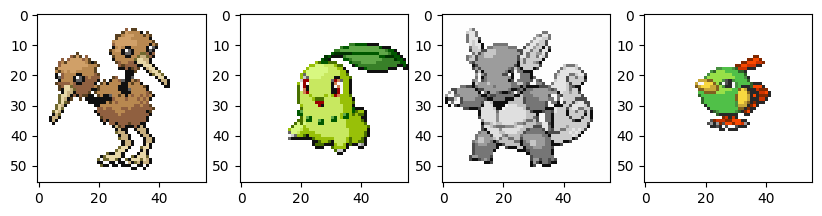

In [4]:
transform = v2.Compose([
    v2.RandomCrop((56, 56)),
    v2.RandomApply([v2.ColorJitter()], 0.2),
    v2.RandomApply([v2.RandomChannelPermutation()], 0.2),
    v2.RandomGrayscale(p = 0.2),
])

source = randint(0, 2)
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([transform(x) for x in x0], dim=0)

fig, axes = plt.subplots(1, 4, figsize=(10, 10))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [5]:
def isigmoid(x):
    eps = 0.05
    return torch.log(x + eps) - torch.log(1 - x + eps)


In [6]:
model = UNet_conditional(3, 3, num_classes=len(all_types)).to(device)

@torch.no_grad
def generate_image():
    model.eval()

    N = 3

    x = torch.randn((N, 3, 64, 64), device=device)

    ty = ["Grass", "Fire", "Water"]
    ty = torch.tensor([all_types.index(t) for t in ty], device=device)
    #print(ty)

    for t in reversed(range(T)):
        tt = torch.tensor([t] * N, device=device)

        z = torch.randn_like(x)
        if t == 0:
            z *= 0

        #x0 = model(x, tt)
        #x = torch.sqrt(alpha_[t]) * x0 + torch.sqrt(1-alpha_[t]) * z

        e = model(x, tt, ty) * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])
        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])
    
    x = torch.sigmoid(x)
    
    fig, axes = plt.subplots(1, N, figsize=(10, 10))
    for i in range(N):
        plot_image(x[i], axes[i])
    plt.show()

    model.train()

In [7]:
#sd = torch.load("model.pt")
#model.load_state_dict(sd)

#generate_image()

  0%|          | 0/100001 [00:00<?, ?it/s]

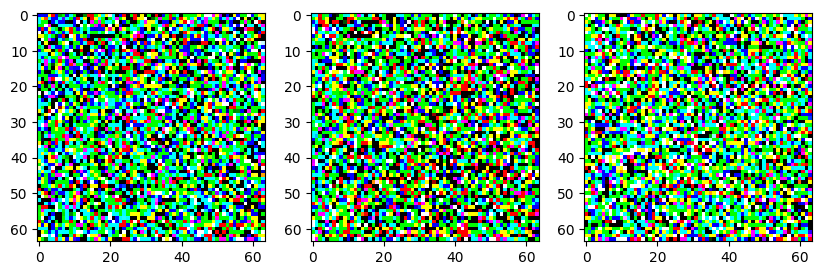

0.05996010:   1%|          | 999/100001 [00:53<1:22:46, 19.93it/s]

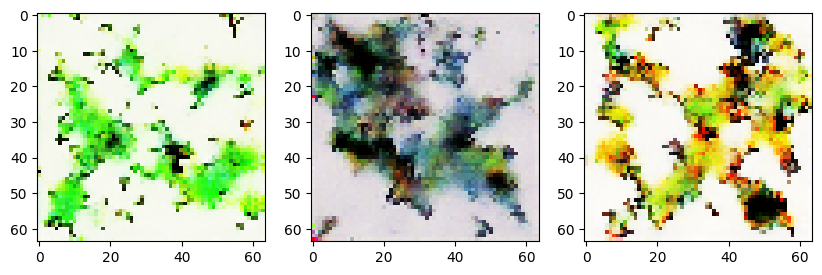

0.06938849:   2%|▏         | 2000/100001 [01:45<1:22:11, 19.87it/s] 

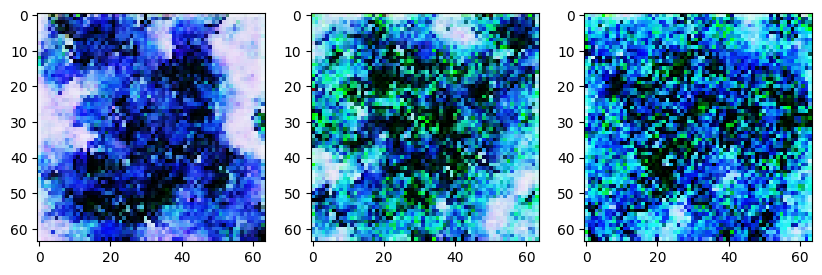

0.01913437:   3%|▎         | 3000/100001 [02:38<1:21:19, 19.88it/s] 

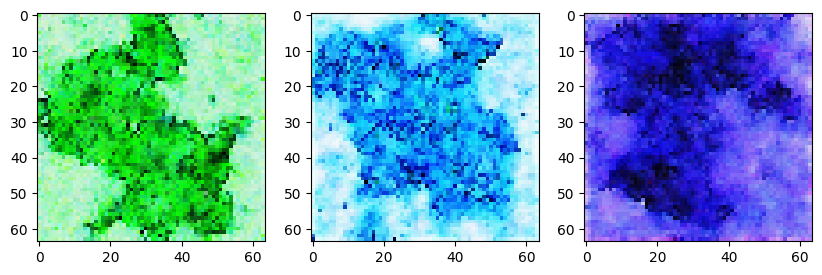

0.04819996:   4%|▍         | 3999/100001 [03:31<1:20:29, 19.88it/s] 

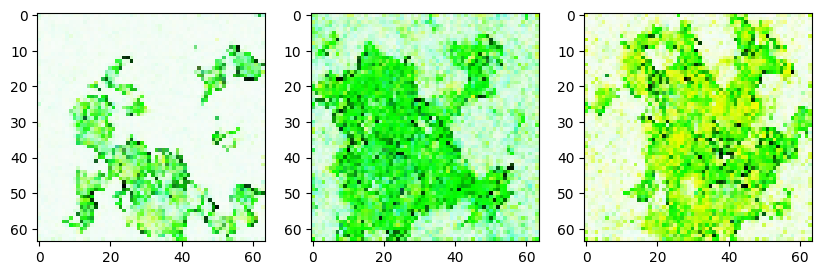

0.02591445:   5%|▍         | 5000/100001 [04:23<1:19:37, 19.88it/s] 

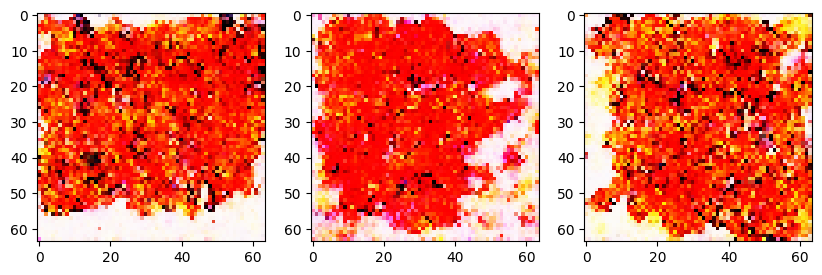

0.03558896:   6%|▌         | 5998/100001 [05:16<1:18:26, 19.97it/s] 

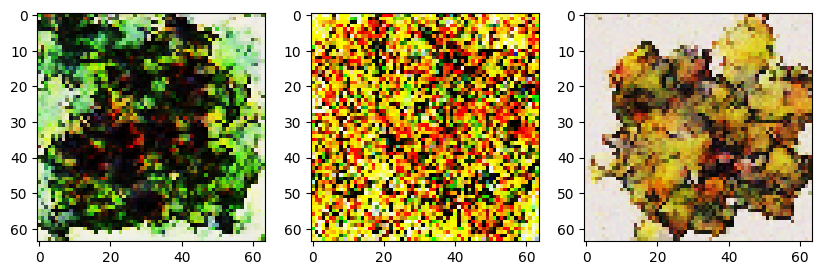

0.02820572:   7%|▋         | 6999/100001 [06:09<1:18:09, 19.83it/s]

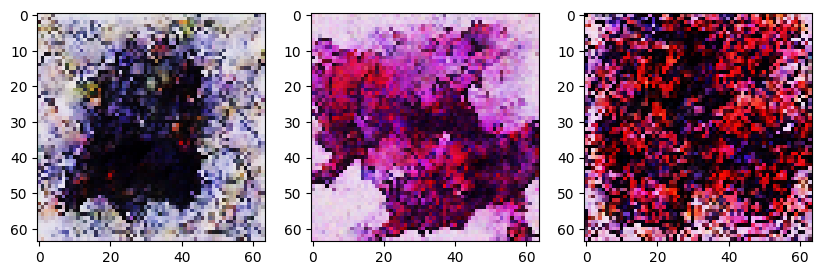

0.03025694:   8%|▊         | 7999/100001 [07:02<1:17:05, 19.89it/s] 

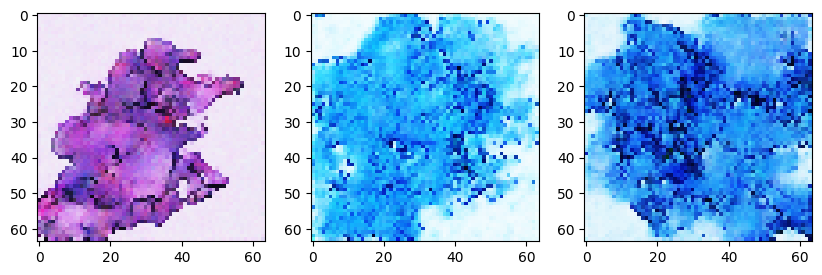

0.04239779:   9%|▉         | 9000/100001 [07:55<1:16:31, 19.82it/s] 

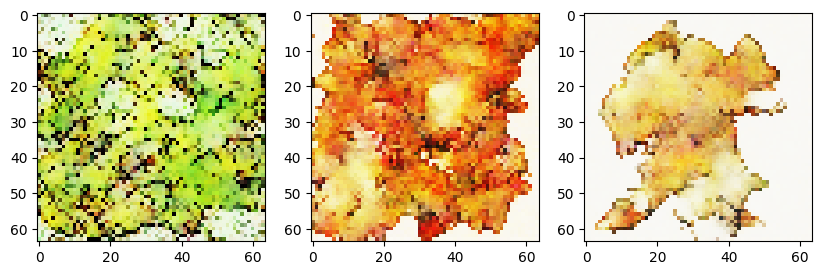

0.01857773:  10%|▉         | 10000/100001 [08:47<1:15:22, 19.90it/s]

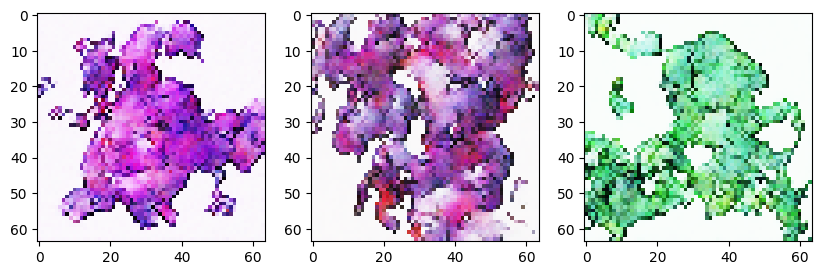

0.06607586:  11%|█         | 10999/100001 [09:40<1:14:34, 19.89it/s] 

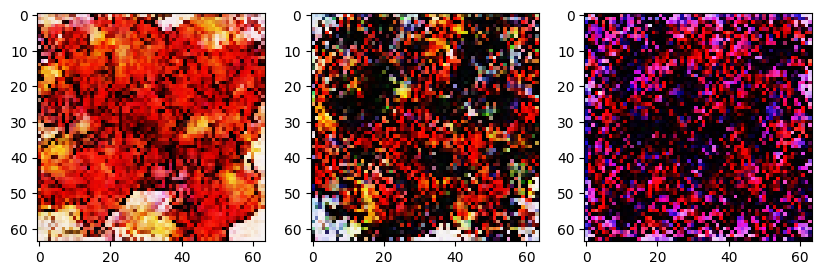

0.02826060:  12%|█▏        | 11999/100001 [10:33<1:13:58, 19.83it/s] 

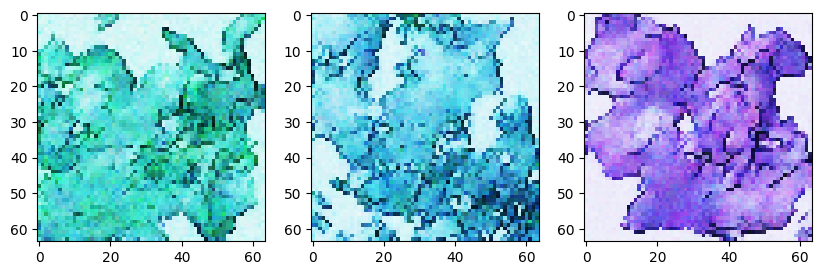

0.01600769:  13%|█▎        | 13000/100001 [11:26<1:13:03, 19.85it/s] 

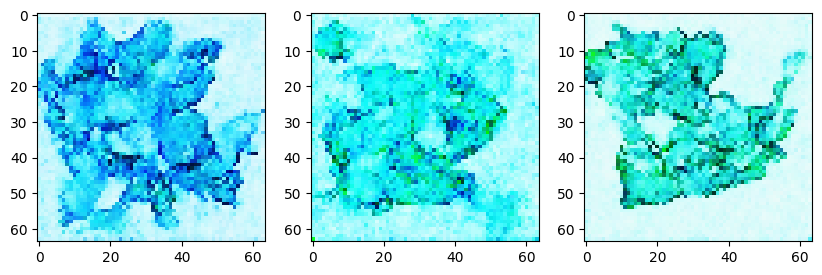

0.02646119:  14%|█▍        | 13999/100001 [12:19<1:12:45, 19.70it/s]

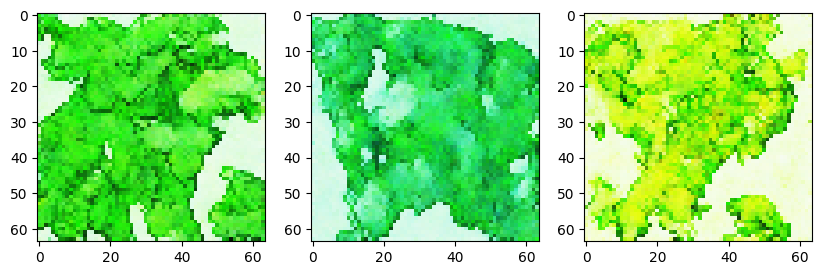

0.01783614:  15%|█▍        | 14999/100001 [13:12<1:12:05, 19.65it/s]

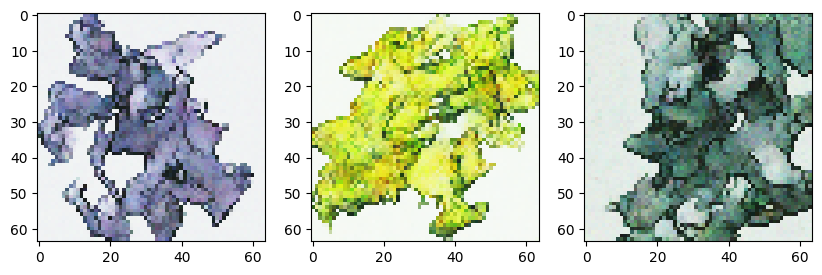

0.02747121:  16%|█▌        | 15999/100001 [14:05<1:10:46, 19.78it/s]

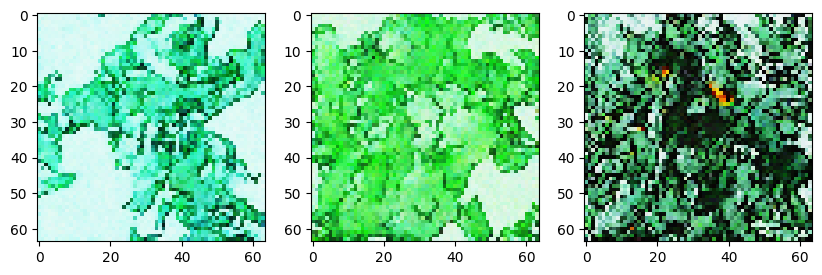

0.01771865:  17%|█▋        | 16999/100001 [14:58<1:09:31, 19.90it/s]

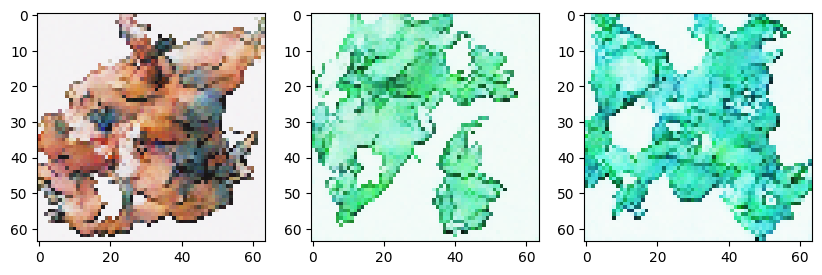

0.03634195:  18%|█▊        | 17999/100001 [15:51<1:08:56, 19.82it/s]

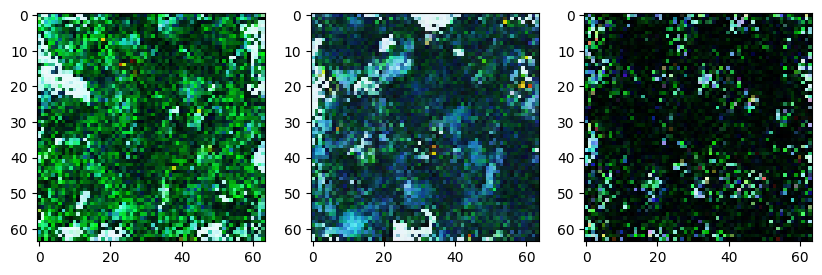

0.02269633:  19%|█▉        | 18999/100001 [16:44<1:07:55, 19.88it/s]

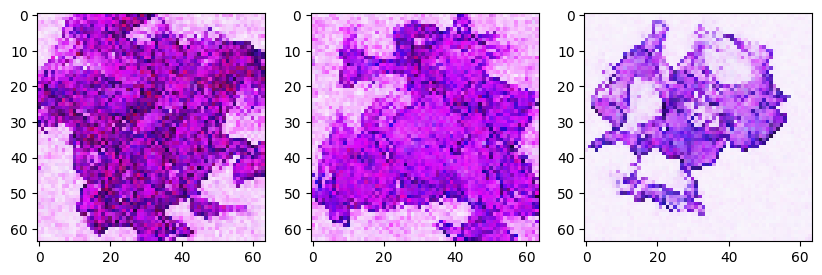

0.02146971:  20%|█▉        | 19999/100001 [17:36<1:07:10, 19.85it/s]

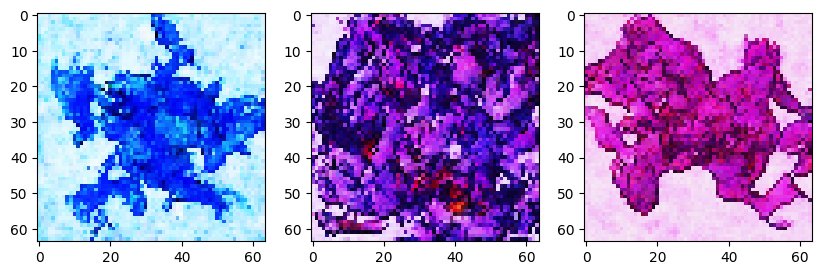

0.05258308:  21%|██        | 21000/100001 [18:29<1:06:14, 19.88it/s]

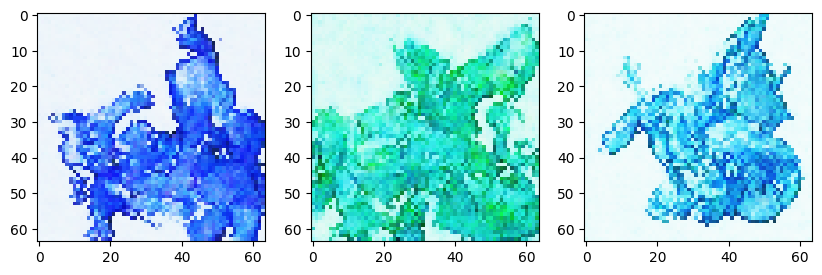

0.03670290:  22%|██▏       | 21999/100001 [19:22<1:05:17, 19.91it/s]

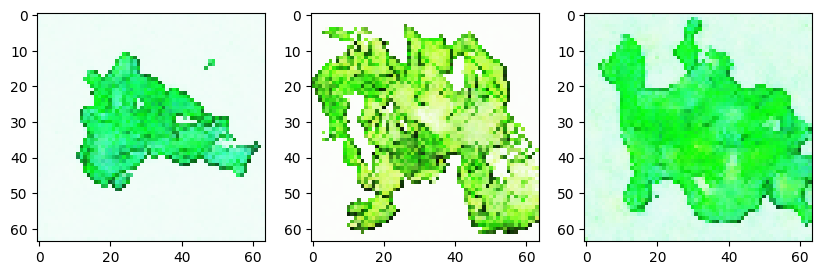

0.02838440:  23%|██▎       | 23000/100001 [20:14<1:04:33, 19.88it/s]

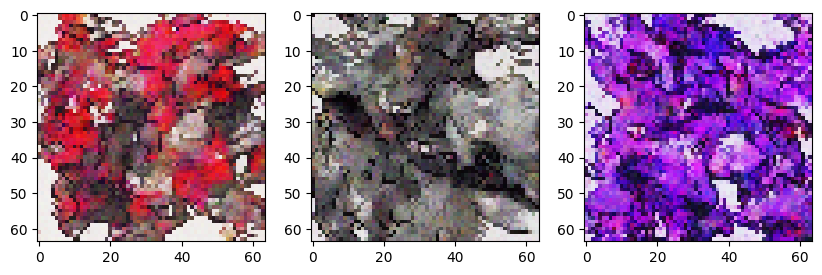

0.02769740:  24%|██▍       | 23999/100001 [21:07<1:03:37, 19.91it/s]

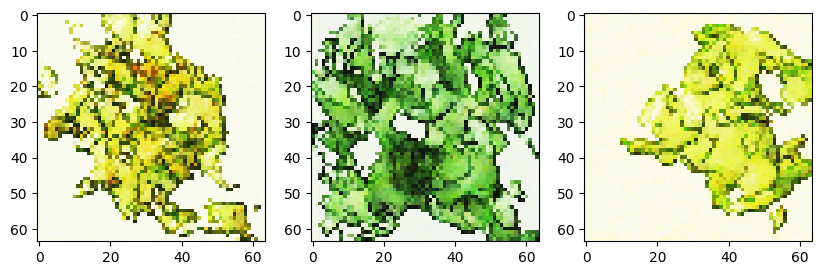

0.02092091:  25%|██▍       | 25000/100001 [22:00<1:02:49, 19.90it/s]

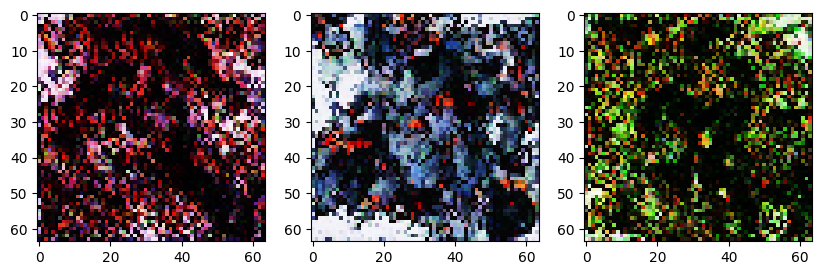

0.03418228:  26%|██▌       | 25999/100001 [22:53<1:02:05, 19.86it/s]

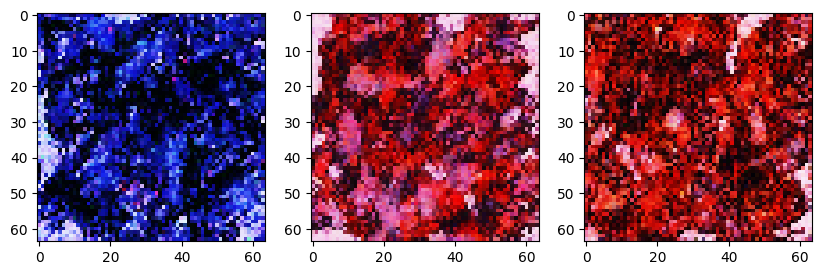

0.01626306:  27%|██▋       | 26999/100001 [23:45<1:01:15, 19.86it/s]

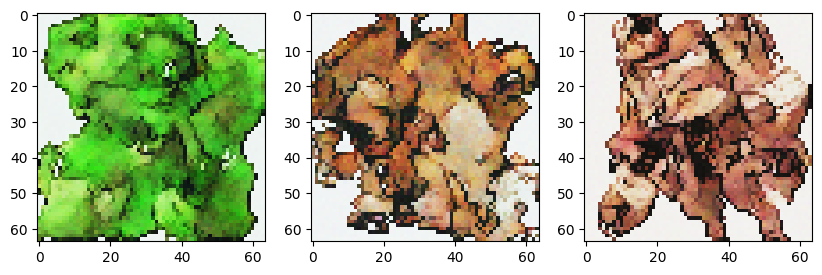

0.02073124:  28%|██▊       | 27999/100001 [24:38<1:00:18, 19.90it/s]

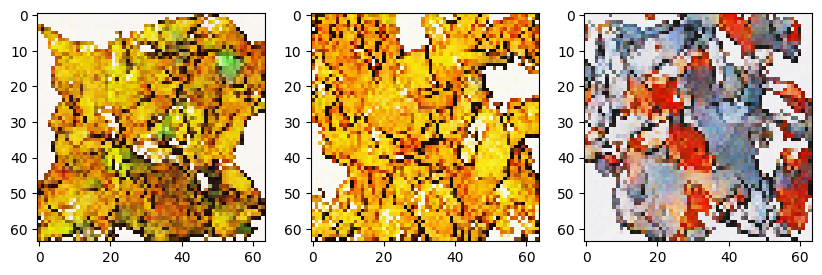

0.01293294:  29%|██▉       | 29000/100001 [25:31<59:37, 19.84it/s]  

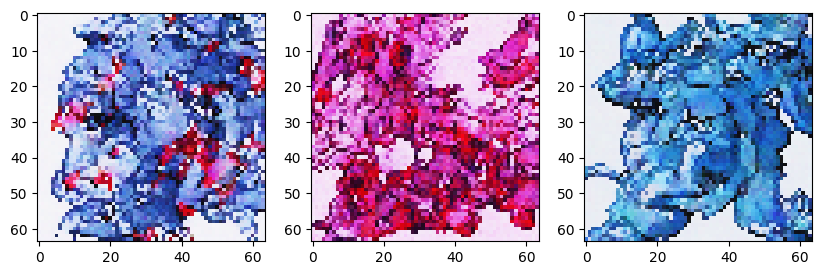

0.02548785:  30%|██▉       | 29999/100001 [26:24<58:51, 19.82it/s]  

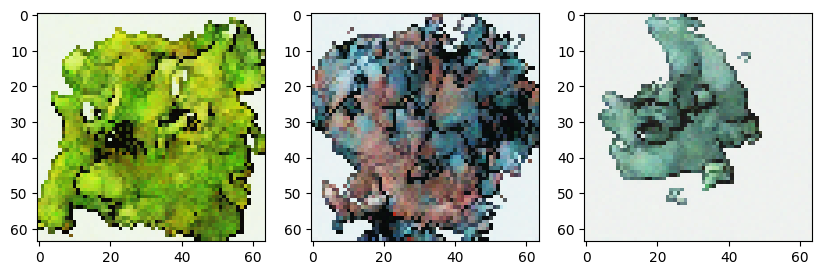

0.02312998:  31%|███       | 31000/100001 [27:17<57:48, 19.89it/s]  

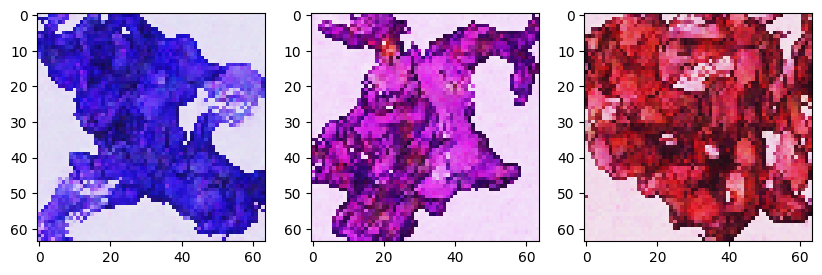

0.04515651:  32%|███▏      | 31999/100001 [28:09<56:57, 19.90it/s]  

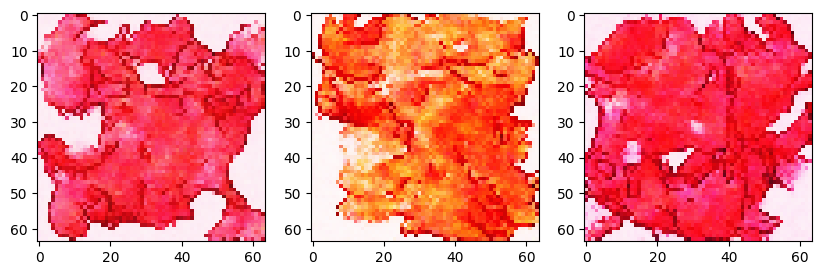

0.04322934:  33%|███▎      | 32999/100001 [29:02<56:02, 19.93it/s]  

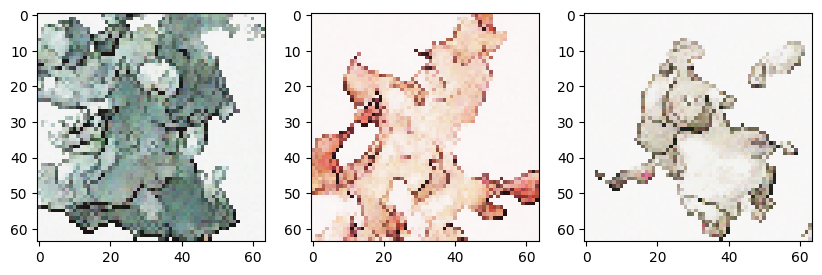

0.01405699:  34%|███▍      | 33999/100001 [29:55<55:19, 19.88it/s]  

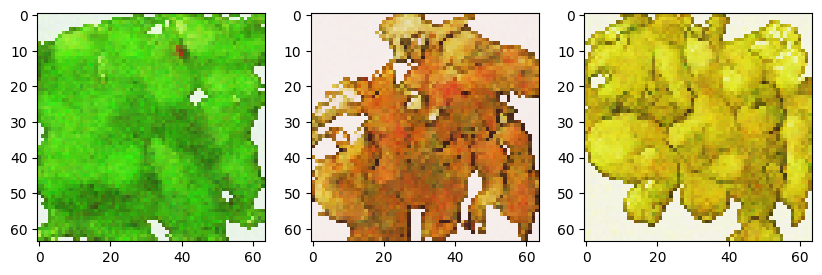

0.03157626:  35%|███▍      | 34999/100001 [30:47<54:29, 19.88it/s]  

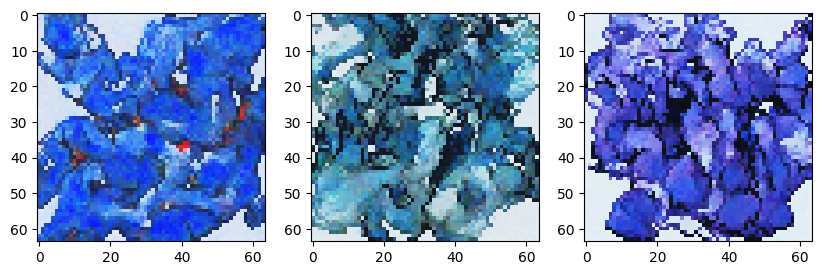

0.03041381:  36%|███▌      | 36000/100001 [31:40<53:35, 19.90it/s]  

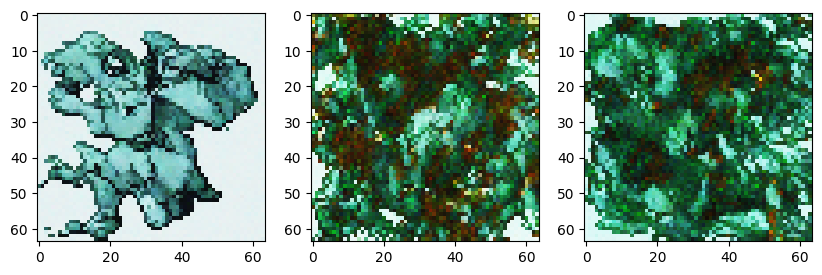

0.01560689:  37%|███▋      | 36999/100001 [32:33<52:51, 19.87it/s]  

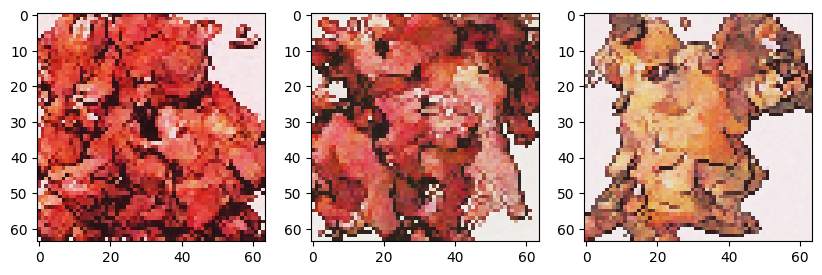

0.03034885:  38%|███▊      | 38000/100001 [33:26<51:59, 19.88it/s]  

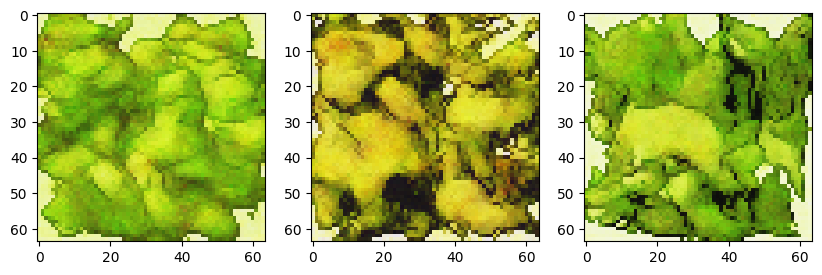

0.05061043:  39%|███▉      | 38999/100001 [34:18<51:11, 19.86it/s]  

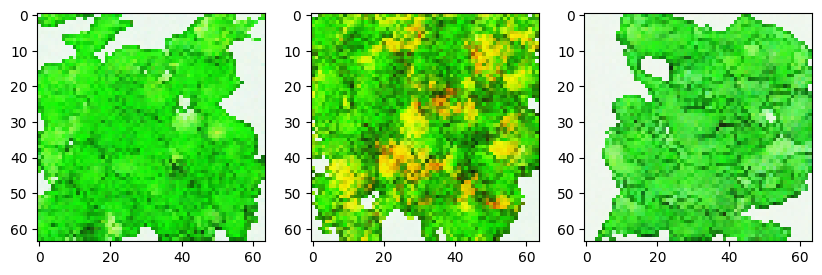

0.02372649:  40%|███▉      | 39999/100001 [35:11<50:25, 19.83it/s]  

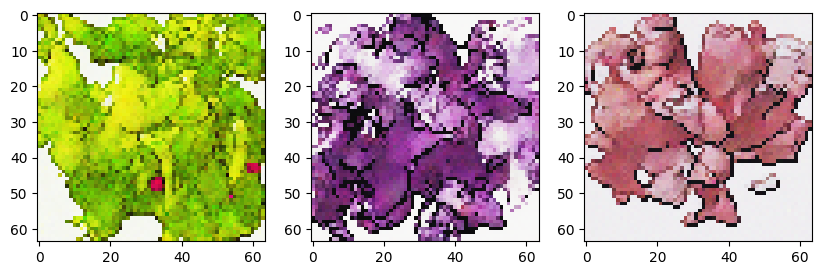

0.04810960:  41%|████      | 41000/100001 [36:04<49:33, 19.85it/s]  

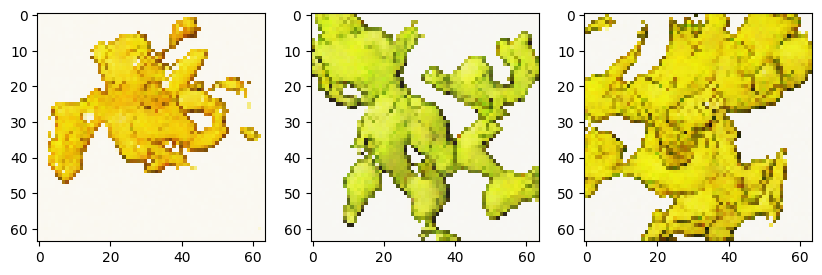

0.04024382:  42%|████▏     | 41999/100001 [36:57<48:20, 20.00it/s]  

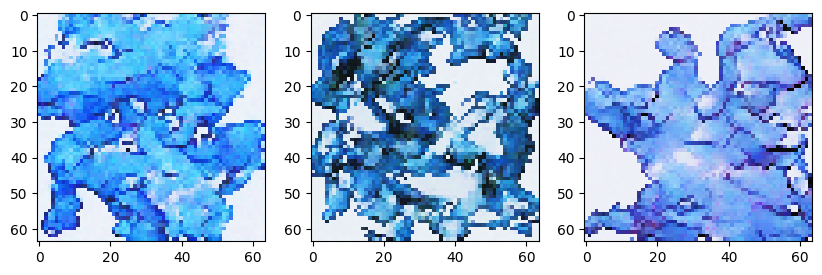

0.02716544:  43%|████▎     | 42999/100001 [37:49<47:36, 19.96it/s]  

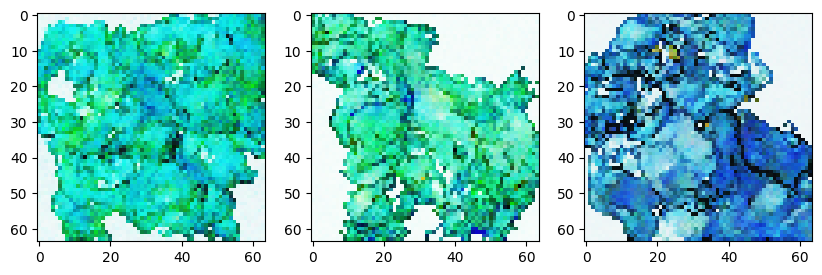

0.02507755:  44%|████▍     | 44000/100001 [38:42<46:57, 19.87it/s]  

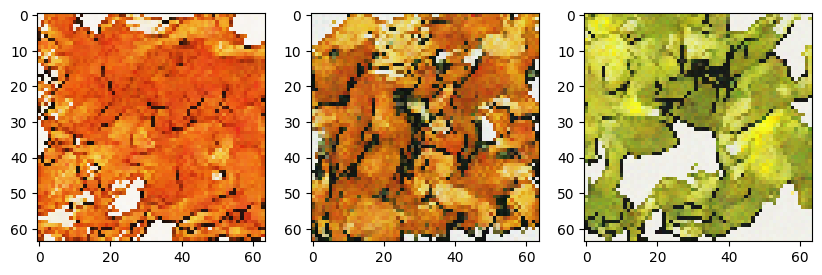

0.02310664:  45%|████▍     | 44999/100001 [39:35<46:05, 19.89it/s]  

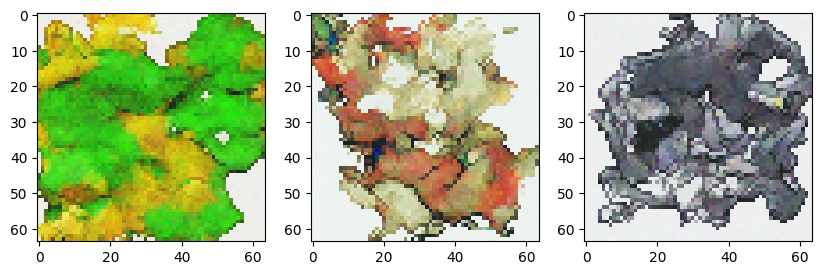

0.01140843:  46%|████▌     | 46000/100001 [40:28<45:23, 19.83it/s]  

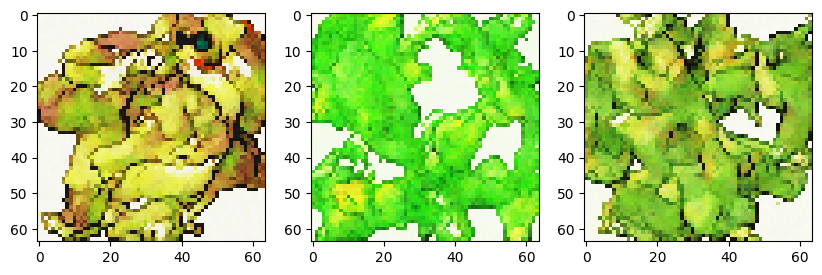

0.04280235:  47%|████▋     | 46999/100001 [41:20<44:35, 19.81it/s]  

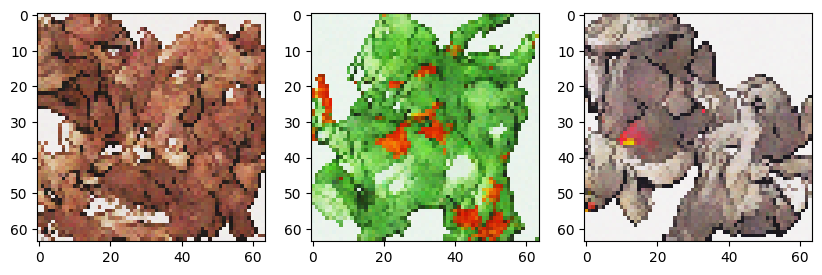

0.04390499:  48%|████▊     | 47999/100001 [42:13<43:40, 19.85it/s]  

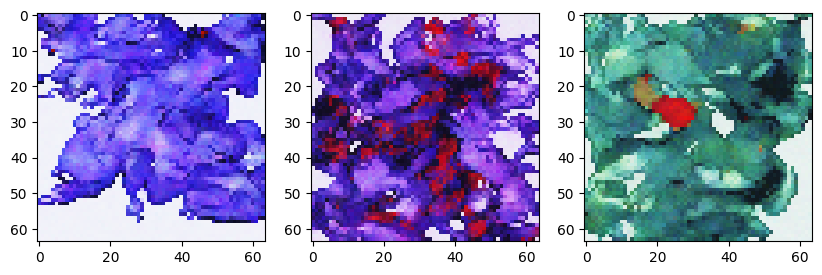

0.01543666:  49%|████▉     | 48999/100001 [43:06<42:52, 19.82it/s]  

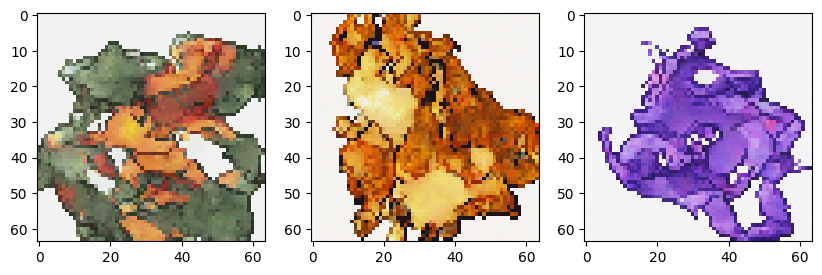

0.02941060:  50%|████▉     | 49999/100001 [43:59<41:55, 19.88it/s]  

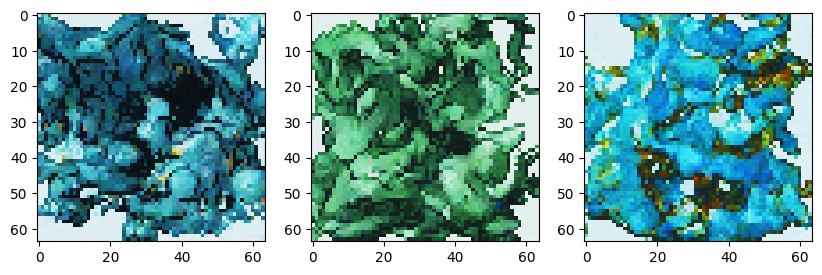

0.02611700:  51%|█████     | 50999/100001 [44:52<41:10, 19.84it/s]  

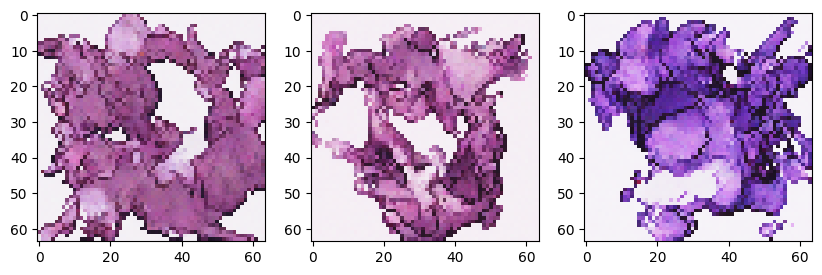

0.01633674:  52%|█████▏    | 51999/100001 [45:44<40:13, 19.89it/s]  

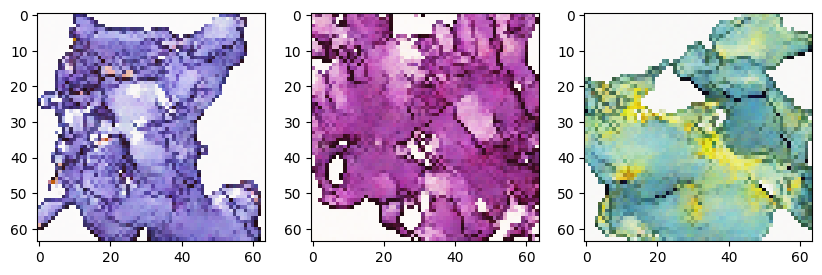

0.01721083:  53%|█████▎    | 53000/100001 [46:37<39:29, 19.84it/s]  

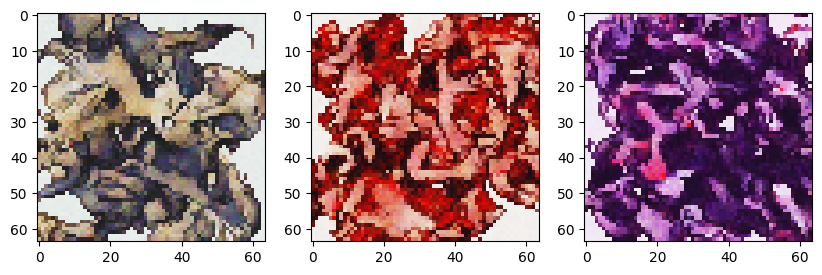

0.00941611:  54%|█████▍    | 54000/100001 [47:30<38:34, 19.88it/s]  

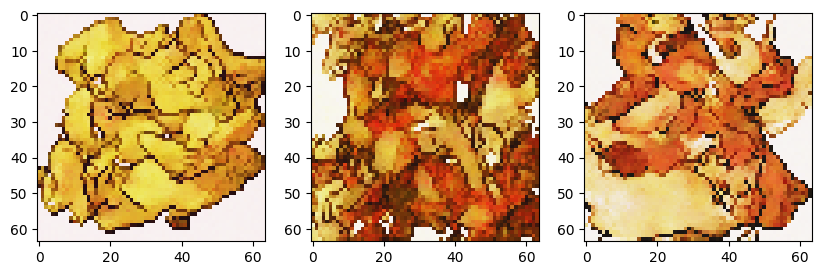

0.01812679:  55%|█████▍    | 55000/100001 [48:23<37:44, 19.88it/s]  

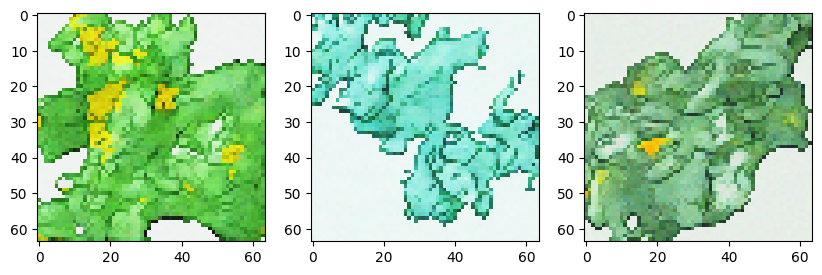

0.04106493:  56%|█████▌    | 56000/100001 [49:15<36:56, 19.85it/s]  

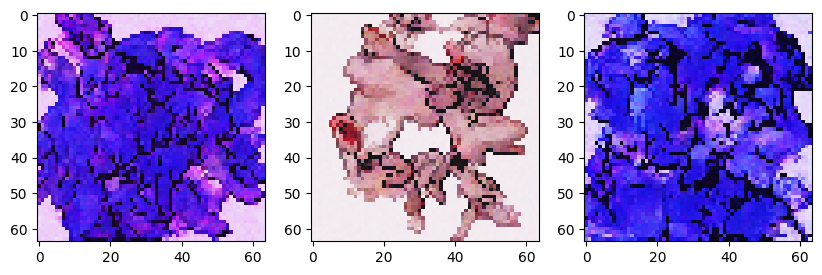

0.02080991:  57%|█████▋    | 57000/100001 [50:08<36:06, 19.85it/s]  

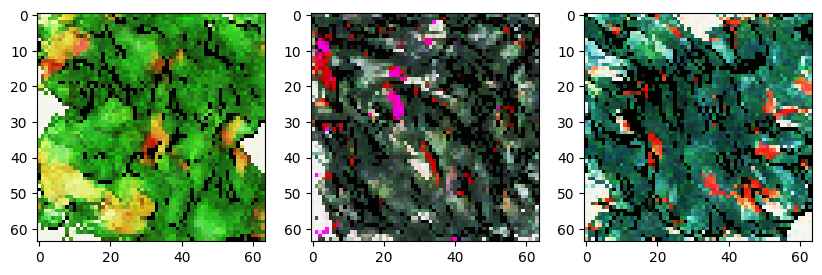

0.02340936:  58%|█████▊    | 58000/100001 [51:01<35:17, 19.83it/s]  

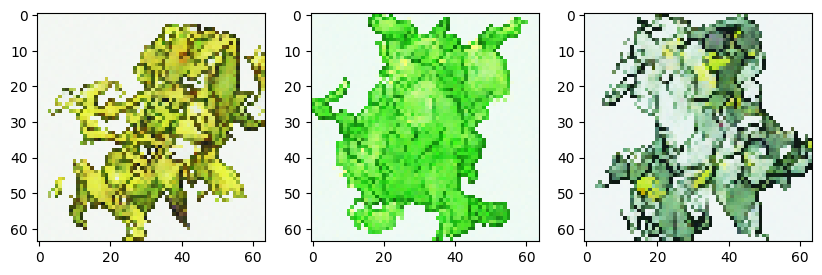

0.01858209:  59%|█████▉    | 58999/100001 [51:54<34:20, 19.90it/s]  

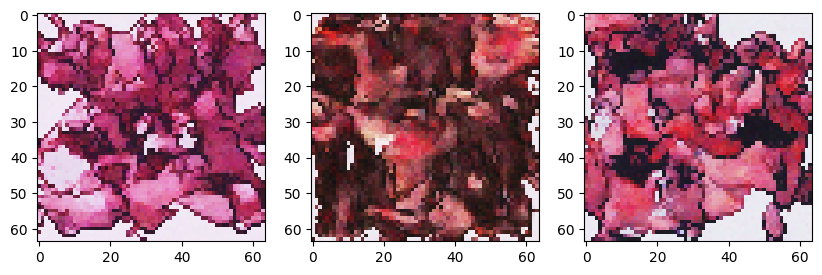

0.02961405:  60%|█████▉    | 59999/100001 [52:46<33:34, 19.86it/s]  

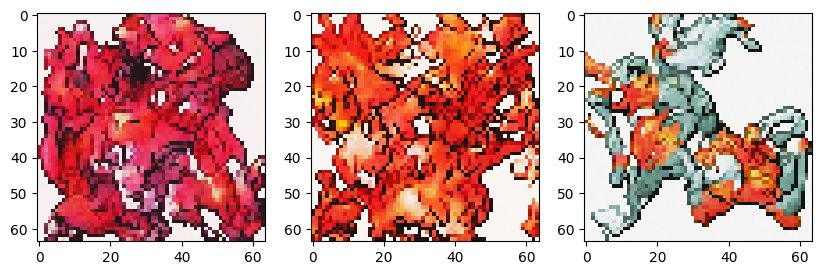

0.03741840:  61%|██████    | 61000/100001 [53:39<32:46, 19.84it/s]  

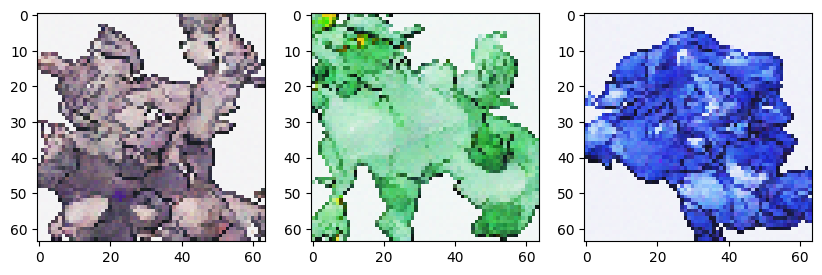

0.02773783:  62%|██████▏   | 61999/100001 [54:32<31:52, 19.87it/s]  

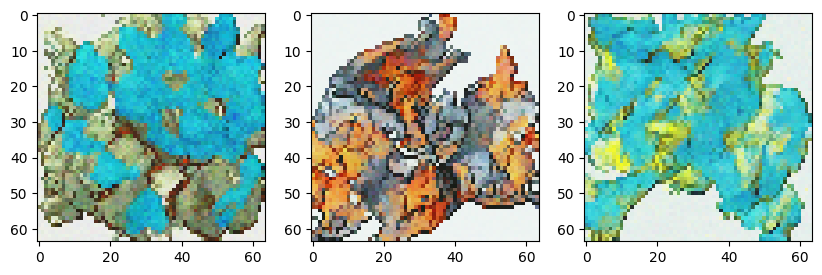

0.03725480:  63%|██████▎   | 62998/100001 [55:25<30:46, 20.04it/s]  

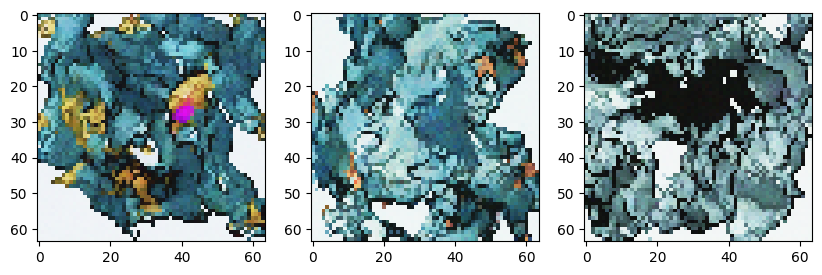

0.01831575:  64%|██████▍   | 64000/100001 [56:17<30:08, 19.91it/s]  

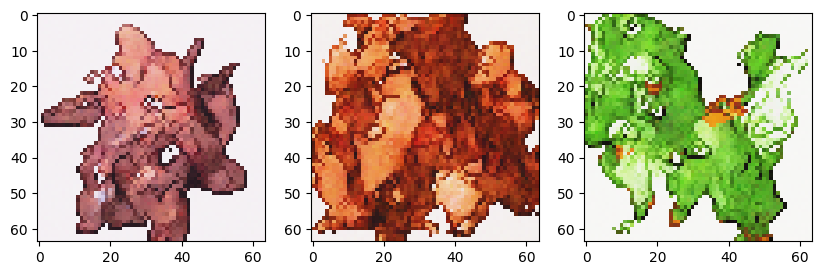

0.04160229:  65%|██████▍   | 64999/100001 [57:10<29:21, 19.87it/s]  

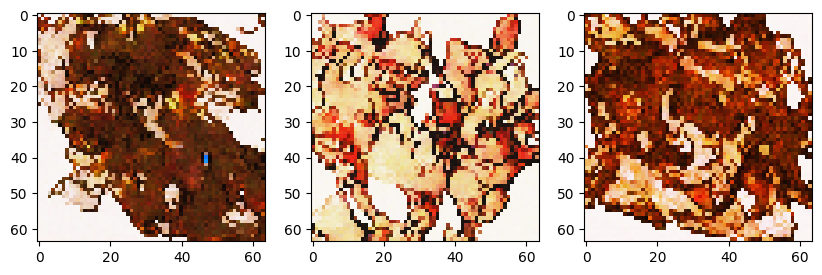

0.00902377:  66%|██████▌   | 65999/100001 [58:03<28:32, 19.86it/s]  

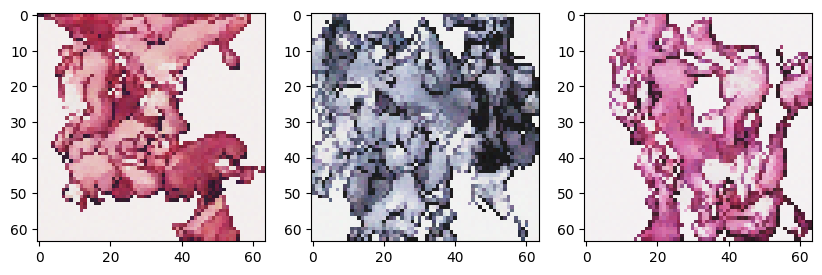

0.02729569:  67%|██████▋   | 66999/100001 [58:56<27:46, 19.80it/s]  

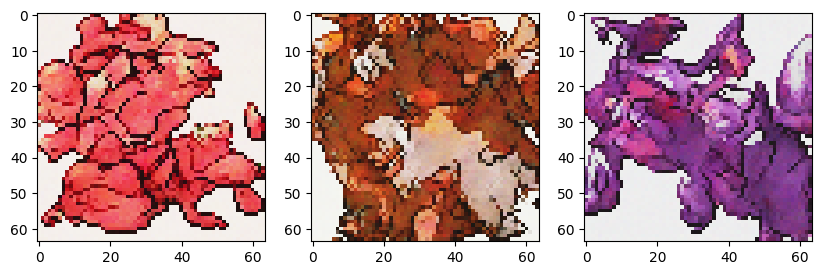

0.04181625:  68%|██████▊   | 68000/100001 [59:49<26:56, 19.80it/s]  

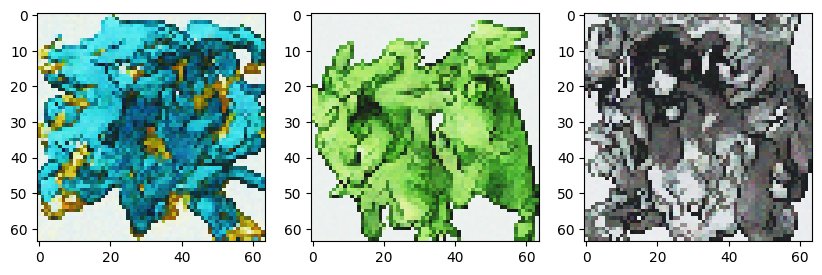

0.03269831:  69%|██████▉   | 68999/100001 [1:00:41<26:04, 19.82it/s]

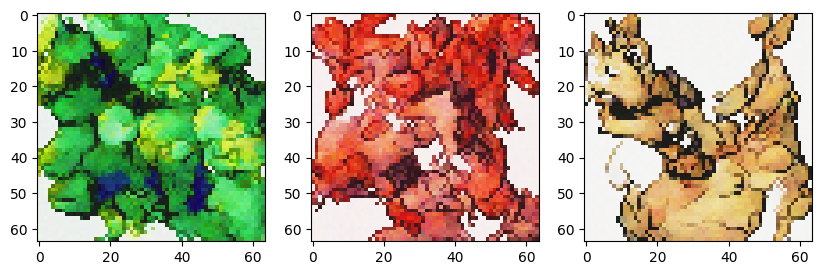

0.02702712:  70%|██████▉   | 70000/100001 [1:01:34<25:06, 19.91it/s]  

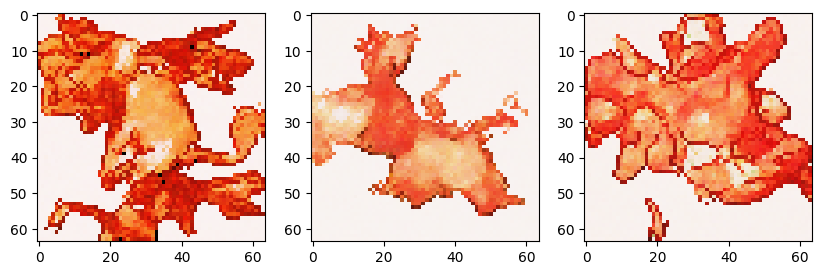

0.01432113:  71%|███████   | 70999/100001 [1:02:27<24:20, 19.86it/s]  

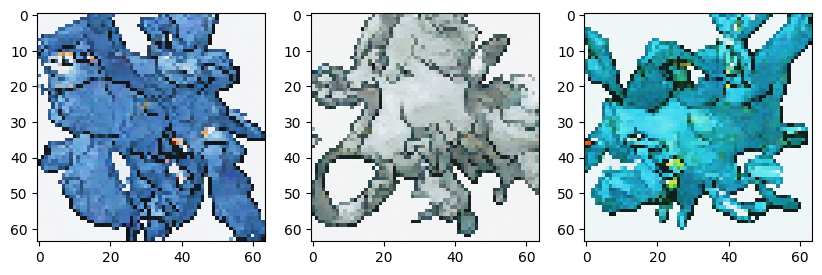

0.02258467:  72%|███████▏  | 72000/100001 [1:03:20<23:30, 19.85it/s]  

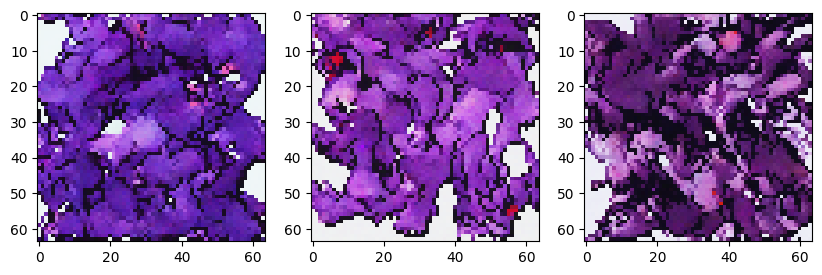

0.01295976:  73%|███████▎  | 72999/100001 [1:04:12<22:39, 19.86it/s]  

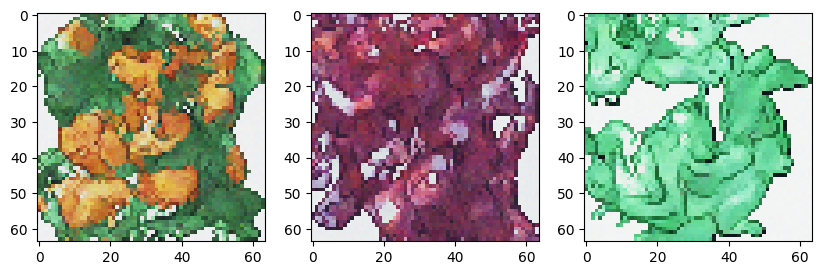

0.01765712:  74%|███████▍  | 73999/100001 [1:05:05<21:47, 19.89it/s]  

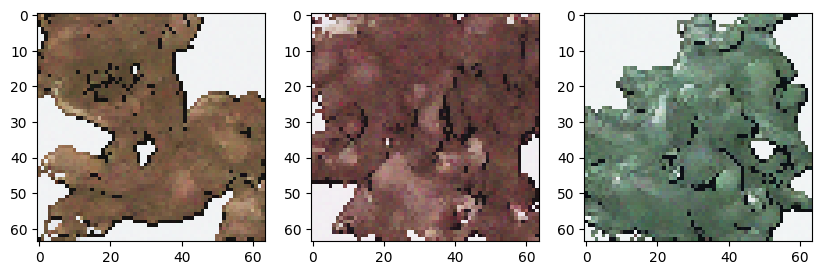

0.01638423:  75%|███████▍  | 74999/100001 [1:05:58<20:59, 19.85it/s]  

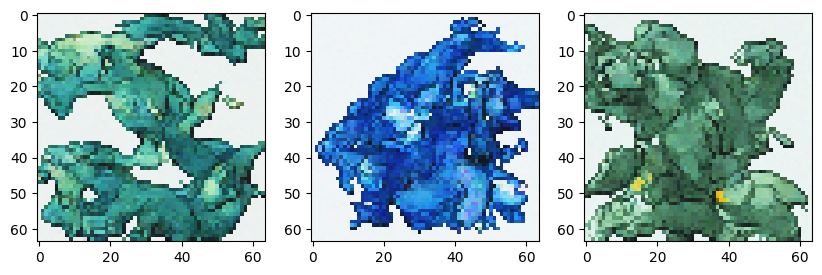

0.00799995:  76%|███████▌  | 75999/100001 [1:06:51<20:07, 19.87it/s]  

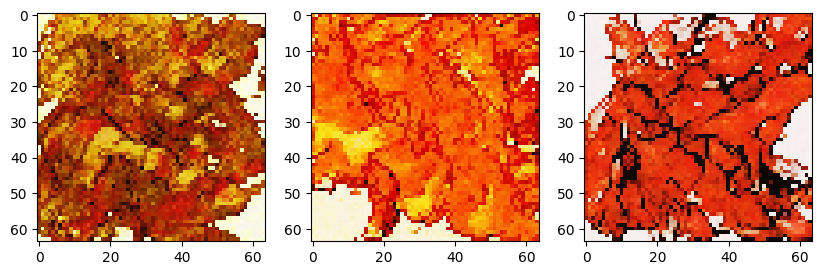

0.01056294:  77%|███████▋  | 76999/100001 [1:07:43<19:18, 19.86it/s]  

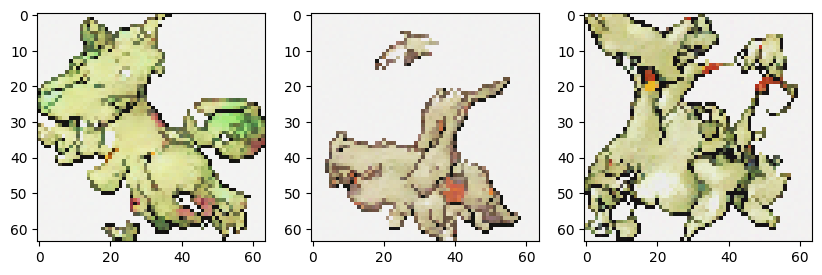

0.02179115:  78%|███████▊  | 78000/100001 [1:08:36<18:28, 19.85it/s]  

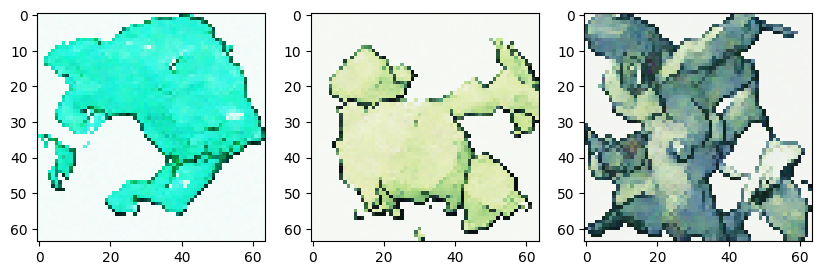

0.03595968:  79%|███████▉  | 79000/100001 [1:09:29<17:37, 19.86it/s]  

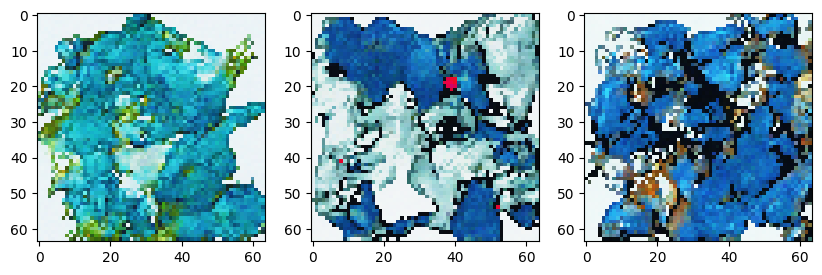

0.03493735:  80%|███████▉  | 80000/100001 [1:10:22<16:50, 19.80it/s]  

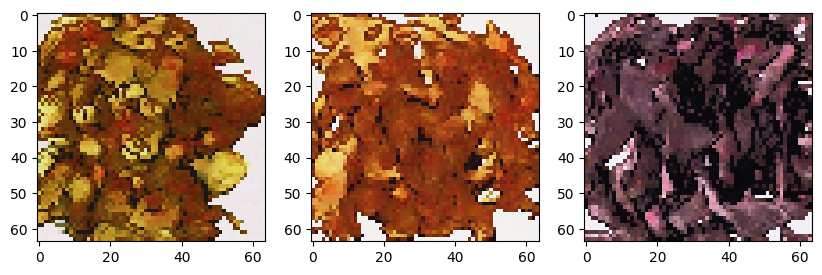

0.03444764:  81%|████████  | 81000/100001 [1:11:15<15:54, 19.90it/s]  

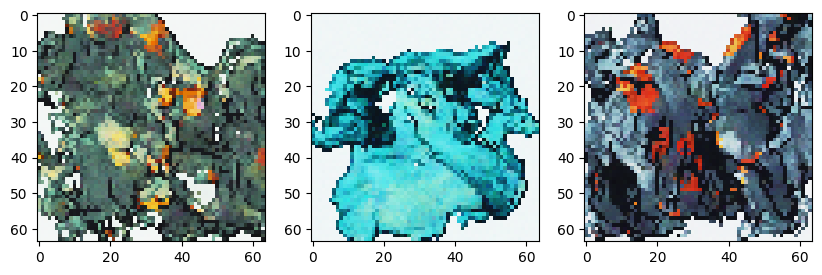

0.00671810:  82%|████████▏ | 81999/100001 [1:12:08<15:07, 19.85it/s]  

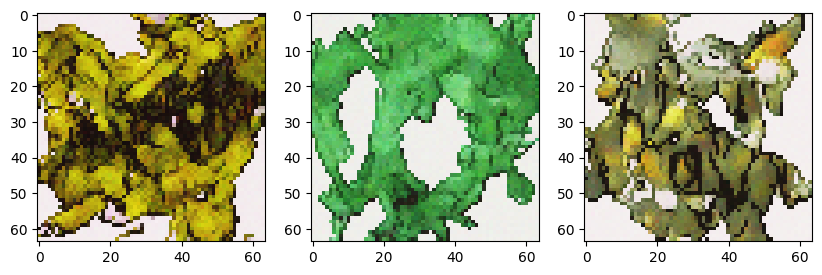

0.02948128:  83%|████████▎ | 82999/100001 [1:13:01<14:15, 19.87it/s]  

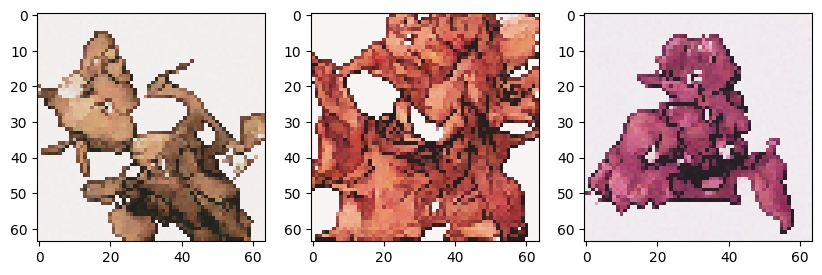

0.03817346:  84%|████████▍ | 84000/100001 [1:13:53<13:28, 19.80it/s]  

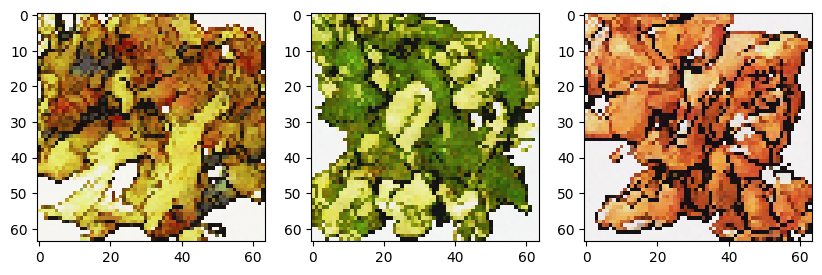

0.03565173:  85%|████████▍ | 84999/100001 [1:14:46<12:36, 19.83it/s]  

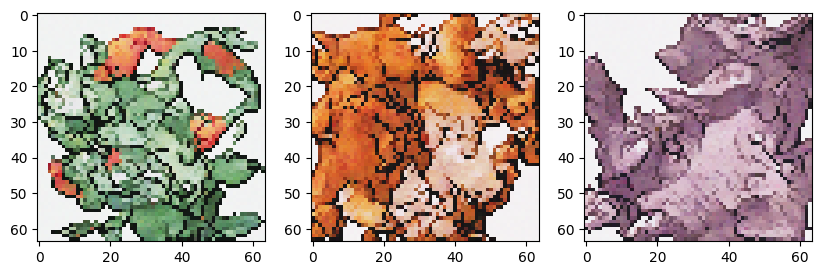

0.03687593:  86%|████████▌ | 85999/100001 [1:15:39<11:46, 19.83it/s]  

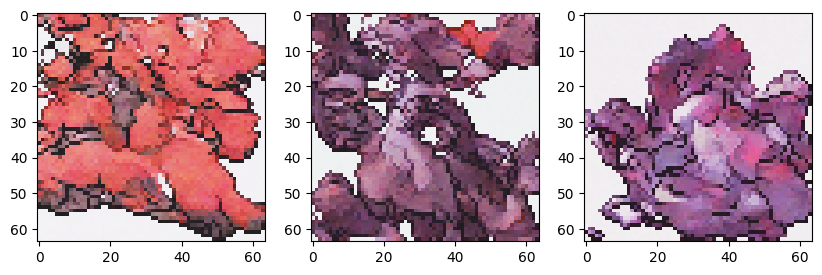

0.02821005:  87%|████████▋ | 87000/100001 [1:16:32<10:55, 19.84it/s]  

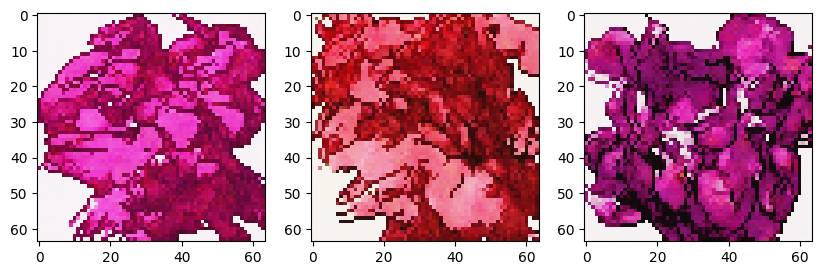

0.01008430:  88%|████████▊ | 87999/100001 [1:17:25<10:02, 19.91it/s]  

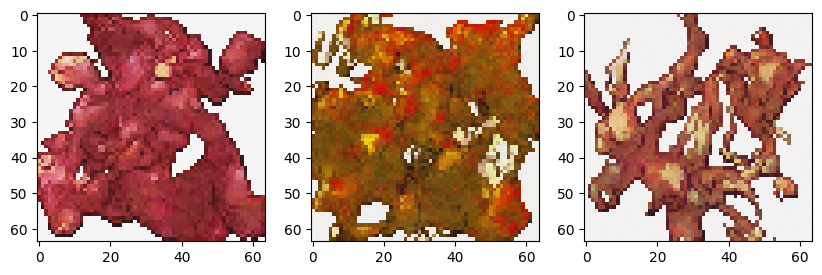

0.04257850:  89%|████████▉ | 88999/100001 [1:18:17<09:12, 19.92it/s]  

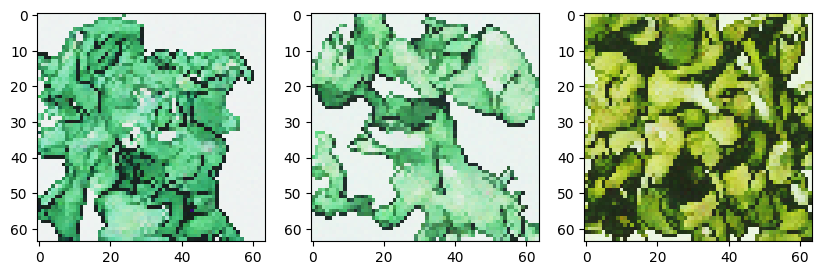

0.01738959:  90%|████████▉ | 89999/100001 [1:19:10<08:21, 19.93it/s]  

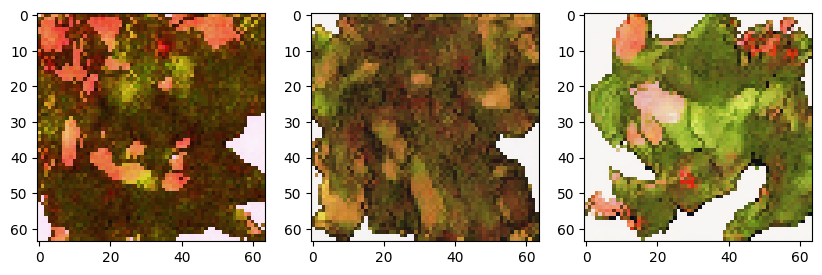

0.02320801:  91%|█████████ | 90999/100001 [1:20:03<07:32, 19.88it/s]  

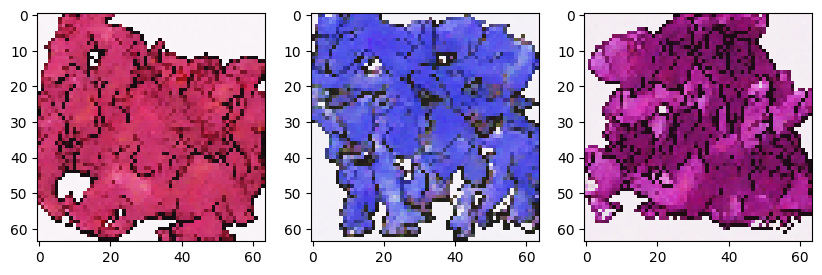

0.01940279:  92%|█████████▏| 91999/100001 [1:20:56<06:44, 19.81it/s]  

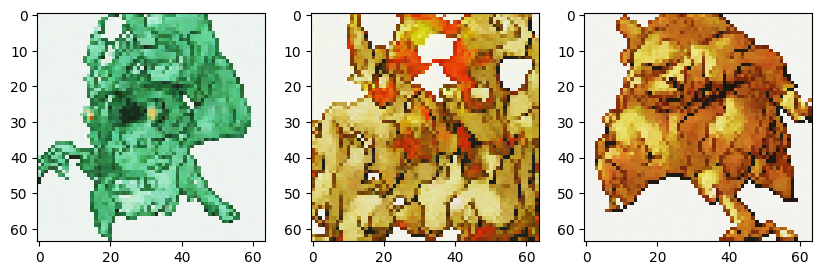

0.02713074:  93%|█████████▎| 92999/100001 [1:21:49<05:52, 19.87it/s]

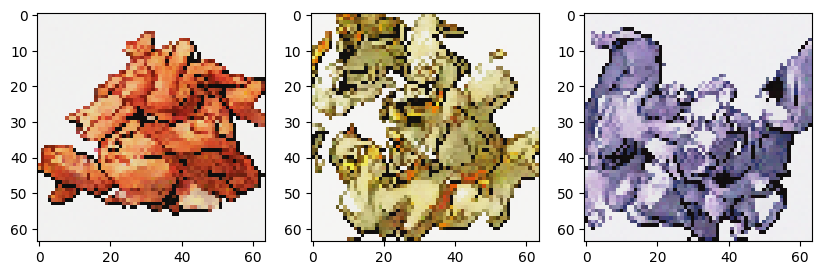

0.01308168:  94%|█████████▍| 94000/100001 [1:22:42<05:01, 19.89it/s]

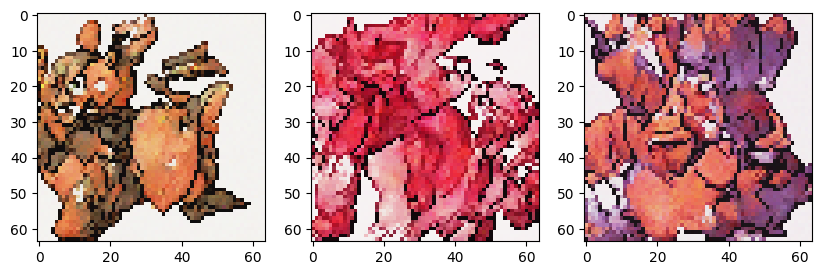

0.00905749:  95%|█████████▍| 94999/100001 [1:23:34<04:12, 19.83it/s]

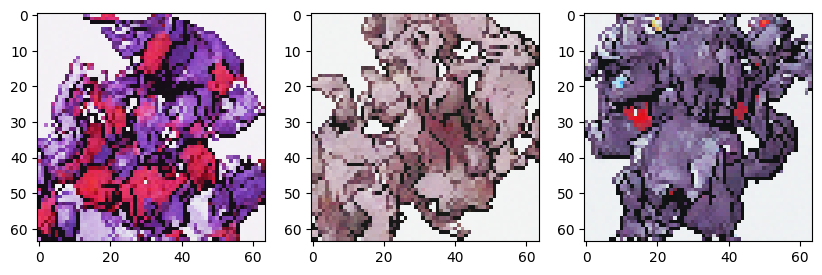

0.02474726:  96%|█████████▌| 96000/100001 [1:24:27<03:21, 19.84it/s]

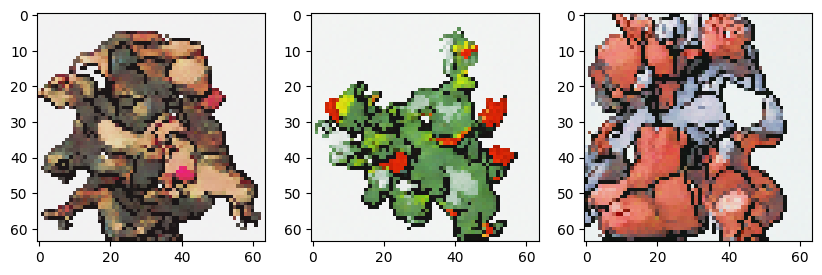

0.02338095:  97%|█████████▋| 96999/100001 [1:25:20<02:31, 19.87it/s]

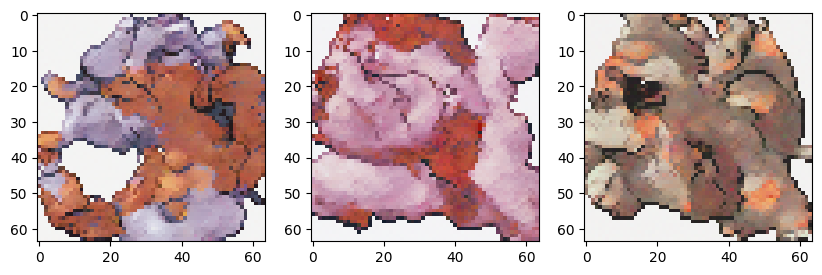

0.00413423:  98%|█████████▊| 98000/100001 [1:26:13<01:40, 19.83it/s]

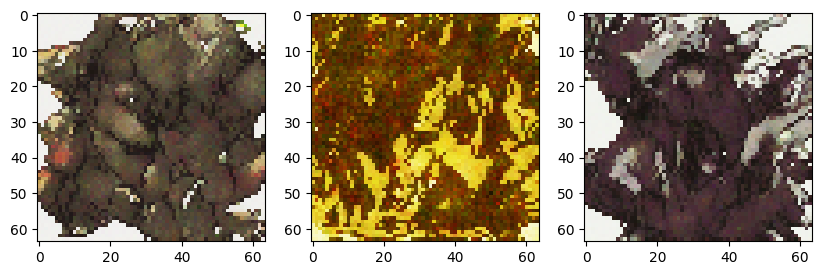

0.02644890:  99%|█████████▉| 99000/100001 [1:27:05<00:50, 19.87it/s]

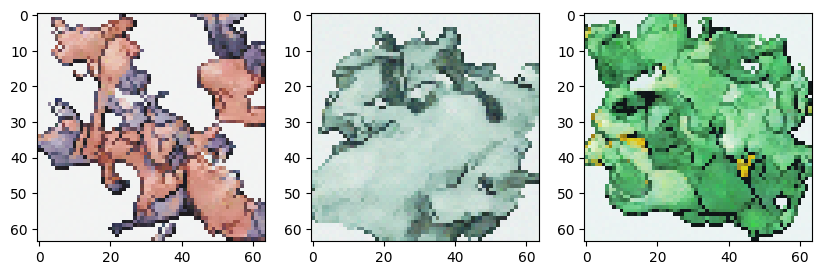

0.02080929: 100%|█████████▉| 100000/100001 [1:27:58<00:00, 19.74it/s]

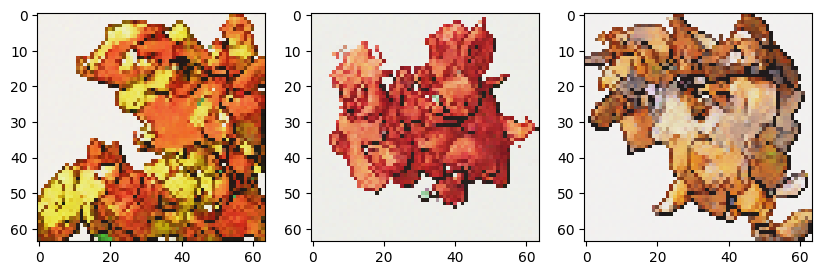

0.03009728: 100%|██████████| 100001/100001 [1:28:01<00:00, 18.93it/s]


In [8]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
pbar = tqdm(range(100001))
def closure():
    optimizer.zero_grad()

    bs = 8

    source = randint(0, 2)
    batch = torch.randperm(385)[:bs]
    x0 = pimages[source, batch]
    x0 = torch.stack([transform(x) for x in x0], dim=0)
    x0 = isigmoid(x0)

    ty = types[batch]

    e = torch.randn_like(x0)
    t = torch.randint(0, T - 1, (bs,), device=device)

    xt = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    ep = model(xt, t, ty)

    loss = loss_func(ep, e)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 1000 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')